In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from os import path, makedirs
from json import load
from collections import Counter, defaultdict
from matplotlib import rcParams

In [3]:
rcParams['font.sans-serif']

['DejaVu Sans',
 'Bitstream Vera Sans',
 'Computer Modern Sans Serif',
 'Lucida Grande',
 'Verdana',
 'Geneva',
 'Lucid',
 'Arial',
 'Helvetica',
 'Avant Garde',
 'sans-serif']

In [4]:
#rcParams['font.sans-serif'] = "Arial"
rcParams['font.family'] = "sans-serif"

# Import data

## Import ESG scores

In [5]:
company_information = pd.read_excel(path.join('..', 'data', 'esgScores.xlsx'))#['Date of Incorporation', 'Date Became Public'])
company_information.index = company_information['Company'] + '|' + company_information['ESG Financial Period']

# Drop unnecessary columns
cols_to_drops = [col for col in company_information.columns if 'grade' in col.lower()]
cols_to_drops.extend(['Refinitiv Company Name', 'Ticker', 'Refinitiv Ticker', 'ISIN'])
company_information.drop(cols_to_drops, axis=1, inplace=True)  

# Convert to numeric the financial period (FY2019 -> 2019)
period_cols = ['Financial Period', 'ESG Financial Period']
for col in period_cols:
    company_information[col] = company_information[col].str.replace('FY', '').astype(pd.Int64Dtype())

# Convert the dates to decades
data_cols = ['Date of Incorporation', 'Date Became Public']
for col in data_cols:
    company_information[col] = pd.to_datetime(company_information[col]).dt.year#.round(-1).astype(pd.Int64Dtype())
    
# Drop observations with missing values
company_information.dropna(subset=None, how = 'any', inplace=True)

company_information.info()
display(company_information)

<class 'pandas.core.frame.DataFrame'>
Index: 799 entries, 3M Corporation|FY2021 to Yamana Gold Inc|FY2014
Data columns (total 18 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Company                            799 non-null    object 
 1   Sector                             799 non-null    object 
 2   Industry                           799 non-null    object 
 3   Country of Headquarters            799 non-null    object 
 4   Minor Region of Headquarters       799 non-null    object 
 5   Region of Headquarters             799 non-null    object 
 6   Date of Incorporation              799 non-null    float64
 7   Date Became Public                 799 non-null    float64
 8   Financial Period                   799 non-null    Int64  
 9   Full-Time Employees                799 non-null    float64
 10  Normalized EBITDA (USD billions)   799 non-null    float64
 11  Total Liabilities (USD b

,Company,Sector,Industry,Country of Headquarters,Minor Region of Headquarters,Region of Headquarters,Date of Incorporation,Date Became Public,Financial Period,Full-Time Employees,Normalized EBITDA (USD billions),Total Liabilities (USD billions),Company Market Cap (USD billions),ESG Financial Period,ESG Score,Environmental Pillar Score,Social Pillar Score,Governance Pillar Score
3M Corporation|FY2021,3M Corporation,Industrials,Conglomerates,United States of America,Northern America,Americas,1929.0,1946.0,2021,95000.0,9.4080,32.0260,101.576912,2021,89.780002,89.576446,95.640669,80.538687
3M Corporation|FY2020,3M Corporation,Industrials,Conglomerates,United States of America,Northern America,Americas,1929.0,1946.0,2020,94987.0,8.9410,34.4770,100.822696,2020,92.478783,89.531298,97.483588,88.655051
3M Corporation|FY2019,3M Corporation,Industrials,Conglomerates,United States of America,Northern America,Americas,1929.0,1946.0,2019,96163.0,8.6610,34.5960,101.474109,2019,88.813312,88.326317,96.495574,77.022558
3M Corporation|FY2018,3M Corporation,Industrials,Conglomerates,United States of America,Northern America,Americas,1929.0,1946.0,2018,93516.0,8.2830,26.7040,109.860633,2018,86.449113,88.303202,97.195014,66.237845
3M Corporation|FY2017,3M Corporation,Industrials,Conglomerates,United States of America,Northern America,Americas,1929.0,1946.0,2017,91536.0,8.7420,26.4240,140.188280,2017,87.984892,87.018837,98.010593,73.082159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Yamana Gold Inc|FY2018,Yamana Gold Inc,Basic Materials,Gold,Canada,Northern America,Americas,2020.0,1980.0,2018,5165.0,0.6609,4.0236,2.234646,2018,72.616734,84.101835,71.350234,58.230410
Yamana Gold Inc|FY2017,Yamana Gold Inc,Basic Materials,Gold,Canada,Northern America,Americas,2020.0,1980.0,2017,5372.0,0.6326,4.4499,2.955597,2017,74.541354,76.091810,61.891438,93.050840
Yamana Gold Inc|FY2016,Yamana Gold Inc,Basic Materials,Gold,Canada,Northern America,Americas,2020.0,1980.0,2016,5266.0,0.6385,4.2895,2.660052,2016,71.426172,70.379779,62.452186,87.633369
Yamana Gold Inc|FY2015,Yamana Gold Inc,Basic Materials,Gold,Canada,Northern America,Americas,2020.0,1980.0,2015,6854.0,0.5809,4.6768,1.758113,2015,70.961833,72.082691,61.853325,84.283102


### Filter ESG data according to the year consider for each company

In [6]:
with open(path.join('..', 'outputs', 'genSRL', 'clustered_t80', 'triples_wizardLM_filtering.json')) as json_file:
    triples = load(json_file)

# Retrieve the fiscal year of the company
documents_toIgnore = ['adidas AG', 'AstraZeneca PLC', 'British American Tobacco PLC', 'PepsiCo Inc']
company_fiscalYears = dict()
for company, company_triples in triples.items():
    if company in documents_toIgnore:
        continue
    
    fiscal_years = [triple['properties']['source'].split('-')[0] for triple in company_triples]
    fiscal_years = Counter(fiscal_years).most_common(5)
    
    if len(fiscal_years) == 1:
        company_fiscalYears[company] = int(fiscal_years[0][0])
    else:
        raise Exception(f'The company {company} has more than one fiscal year: {fiscal_years}')
    
# Filter the observations
company_information_filtered = company_information.copy()
company_information_filtered.set_index(['Company', 'ESG Financial Period'], inplace = True)
company_information_filtered.drop(columns = ['Financial Period'], inplace = True)

available_companyInformation = {company: fiscalYear for company, fiscalYear in company_fiscalYears.items() if company_information_filtered.index.isin([(company, fiscalYear)]).any()}
company_information_filtered = company_information_filtered.loc[list(available_companyInformation.items()), :].reset_index(level = 1)
display(company_information_filtered)

missing_information = {company: fiscalYear for company, fiscalYear in company_fiscalYears.items() if company not in list(available_companyInformation.keys())}
print(f'Missing information ({len(missing_information)}):\n' + '-' * 30 + "\n" + '\n'.join([f'{company}: {fiscalYear}' for company, fiscalYear in sorted(missing_information.items())]))

,ESG Financial Period,Sector,Industry,Country of Headquarters,Minor Region of Headquarters,Region of Headquarters,Date of Incorporation,Date Became Public,Full-Time Employees,Normalized EBITDA (USD billions),Total Liabilities (USD billions),Company Market Cap (USD billions),ESG Score,Environmental Pillar Score,Social Pillar Score,Governance Pillar Score
Company,,,,,,,,,,,,,,,,
3i Group plc,2022,Financial Services,Asset Management,United Kingdom,Northern Europe,Europe,1973.0,1994.0,234.0,5.295230,1.568082,19.078431,77.767286,84.709909,62.847959,88.283041
Activision Blizzard Inc,2021,Communication Services,Electronic Gaming & Multimedia,United States of America,Northern America,Americas,2000.0,1983.0,9800.0,3.793000,7.457000,51.819457,68.596577,43.680524,68.990671,75.732035
Adecco Group AG,2021,Industrials,Staffing & Employment Services,Switzerland,Western Europe,Europe,1967.0,2001.0,33000.0,1.191369,9.179683,8.582490,73.498601,44.540741,73.612581,93.623462
Adidas AG,2016,Consumer Cyclical,Footwear & Accessories,Germany,Western Europe,Europe,1989.0,1997.0,58902.0,2.029016,9.150547,33.025452,88.418098,89.477975,95.823996,74.045930
Air Canada,2021,Industrials,Airlines,Canada,Northern America,Americas,2006.0,1988.0,26100.0,-1.158778,24.224315,5.984689,68.044246,66.040424,62.898152,77.824642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Vodafone Group plc,2019,Communication Services,Telecom Services,United Kingdom,Northern Europe,Europe,1984.0,1988.0,98996.0,15.475042,90.458777,52.118728,80.302265,75.586006,85.099528,74.296887
Walmart Inc,2022,Consumer Defensive,Discount Stores,United States of America,Northern America,Americas,1969.0,1972.0,2300000.0,39.142000,161.607000,401.352474,82.966810,86.058028,80.027807,85.179913
Walt Disney Co,2021,Communication Services,Entertainment,United States of America,Northern America,Americas,2018.0,1957.0,190000.0,8.812000,115.056000,281.536730,68.725715,57.867837,86.549616,48.876873


Missing information (37):
------------------------------
3M Corporation: 2022
Alcon Inc: 2022
Alphabet Inc: 2022
American Electric Power Company Inc: 2022
Apple Inc: 2022
Assicurazioni Generali SpA: 2021
AstraZeneca plc: 2021
BPER Banca SpA: 2021
Banco Santander SA: 2021
Bank of America Corp BofA: 2021
British American Tobacco plc: 2021
Campbell Soup Company: 2022
Canon Inc: 2022
Commonwealth Bank of Australia: 2022
Delta Air Lines Inc: 2021
Deutsche Bank AG: 2021
First Republic Bank CA: 2021
GlobalFoundries: 2022
Humana Inc: 2021
Hyundai Motor Co: 2022
Imperial Oil Ltd: 2022
Iveco Group NV: 2022
Kia Corp: 2022
Korean Air Lines Co Ltd: 2022
Kraft Heinz Co The: 2022
LG Display Co Ltd: 2022
National Grid PLC: 2020
Paramount Resources Ltd: 2022
Pepsico Inc: 2020
Poste Italiane: 2017
Royal Bank of Canada: 2021
STMicroelectronics: 2022
Samsung Electronics Co Ltd: 2022
Sligro Food Group NV: 2015
UniCredit SpA: 2021
Virgin Atlantic Ltd: 2020
WESCO International Inc: 2022


# ESG scors by continent

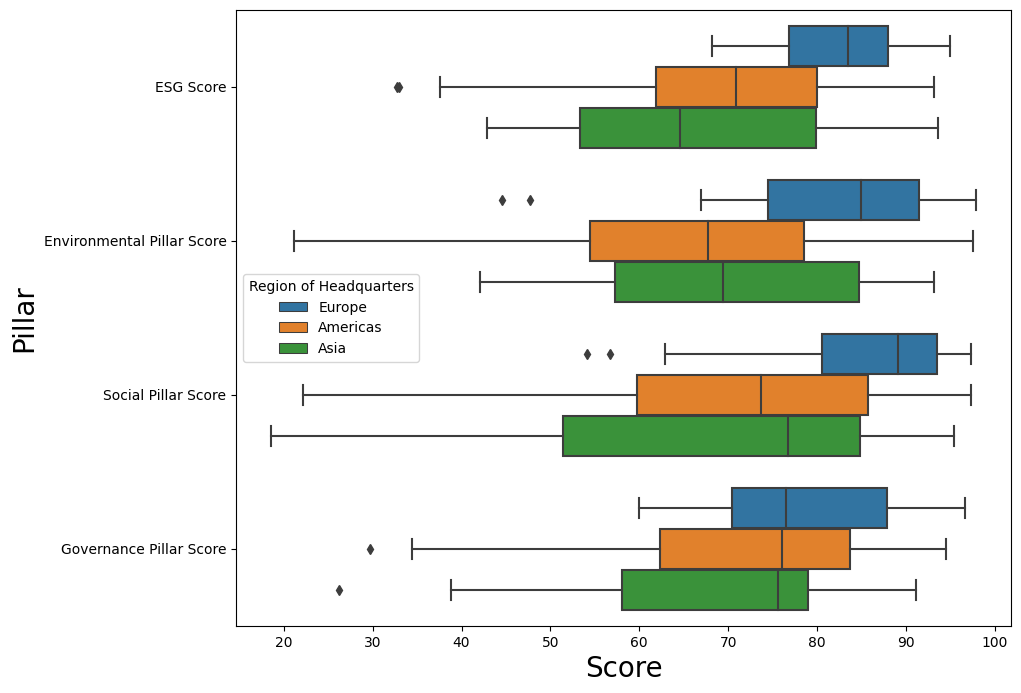

In [7]:
features = ['Region of Headquarters', 'ESG Score', 'Environmental Pillar Score', 'Social Pillar Score', 'Governance Pillar Score']
plt.figure(figsize = (10, 8))
#sns.boxplot(data = company_information_filtered, x = features[0])#, orient = 'h', hue = 'Region of Headquarters')
sns.boxplot(data =company_information_filtered[features].melt(id_vars = 'Region of Headquarters'), 
            x = 'value', y = 'variable', orient = 'h', hue = 'Region of Headquarters')
plt.xlabel('Score', fontsize = 20)
plt.ylabel('Pillar', fontsize = 20)
plt.savefig('esgScoresByRegion.pdf', bbox_inches = 'tight')
plt.show()


## Import company actions

In [8]:
def fillUp_matrix(df_row, matrix_df, binary = False):
    for item, counter, in df_row.item().items():
        matrix_df.loc[df_row.name, item] = counter if not binary else 1

In [9]:
# Read the triples
triple_path = path.join('..', 'outputs', 'genSRL', 'clustered_t80', 'triples_wizardLM_filtering.json')
with open(triple_path) as json_file:
    triple_data = load(json_file)

# Save the actions
raw_data = []
for companyName, triples in triple_data.items():
    for triple in triples:
        raw_data.append({
            'company': companyName,
            'category': triple['esg_category'],
            'predicate': triple['predicate'],
            'object': triple['object']
        })
triple_df = pd.DataFrame(raw_data)
triple_df['action'] = triple_df['category'].str.upper() + ': ' + triple_df['predicate'].str.capitalize()

# Generate a dictionary as company: company actions
grouped_attributes = triple_df.groupby(['company']).agg(Counter)
grouped_attributes = grouped_attributes.drop(index = documents_toIgnore)

adj_matrices = dict()
for att in ['category', 'action']:
    
    # Extract the comapny attributes
    campany_attributes = grouped_attributes[att]
    
    # Create the empty matrix
    matrix = pd.DataFrame(data = 0, index = campany_attributes.index, columns = sorted(triple_df[att].unique()))
    
    # Fill up the matrix
    campany_attributes.to_frame().apply(lambda df_row: fillUp_matrix(df_row, matrix_df = matrix), axis = 1)
    adj_matrices[att] = matrix

### Create some metrics based on the company actions

In [10]:

from scipy.stats import entropy
def compute_entropy(items, base = None):
    probs = items / len(items)
    entropy_value = entropy(probs, base = base)
    return entropy_value

def compute_entropyActions(items, base = None):
    items = items[items > 0]
    
    # Unpack the items (category, predicate)
    unpackedItems = pd.DataFrame([(idx.split(': ')[0], idx.split(': ')[1]) for idx in items.index], columns = ['category', 'action'])
    
    # Attach the counter
    unpackedItems = pd.concat([unpackedItems, items.reset_index(drop = True).rename('counter')], axis = 1, ignore_index = False)
    unpackedItems['action'] = unpackedItems.apply(lambda df_row: {df_row['action']: df_row['counter']}, axis = 1)
    unpackedItems = unpackedItems.sort_values(by = ['counter'], ascending = False).drop(columns = ['counter'])
    
    # Group by category
    groupedItems = unpackedItems.groupby(['category']).agg(lambda items: {item: counter for dict_item in items for item, counter in dict_item.items()})
    
    # Normalise counter
    groupedItems['action'] = groupedItems['action'].map(lambda items: {item: round(counter / sum(items.values()), 4) for item, counter in items.items()})
    
    # Compute the entropy for each category
    groupedItems['entropy'] = groupedItems['action'].map(lambda items: entropy(list(items.values()), base = base))
    
    avg_entropy = groupedItems['entropy'].mean()
    median_entropy = groupedItems['entropy'].median()

    return median_entropy

In [11]:
with open(path.join('..', 'data', 'esg_pillars.json')) as jsonFile:
    category_pillar = load(jsonFile)
display(len(category_pillar.keys()))

592

In [12]:
actionBasedfeatures = []

# Feature 1: Top k category per company 
topK = 10 # 10 for ESG 
topCategories = grouped_attributes['category'].map(lambda counter: {cat: (round(count / counter.total(), 4)) for cat, count in counter.items()}).rename(f'disclosedCategory')

if topK > 0:
    topCategories = topCategories.map(lambda counter: dict(sorted(counter.items(), key = lambda item: item[1], reverse=True)[:topK])).rename(f'Top{topK}DisclosedCategories')
actionBasedfeatures.append(topCategories)

# Feature 2A: category entropy
category_entropy = adj_matrices['category'].apply(compute_entropy, axis = 1).rename('Category Entropy').round(2)
actionBasedfeatures.append(category_entropy)

# Feature 2B: category entropy
action_entropy = adj_matrices['action'].apply(compute_entropyActions, axis = 1).rename('Action Entropy').round(2)
actionBasedfeatures.append(action_entropy)

# Feature 3: Pillar percentages
pillarPercentages = grouped_attributes['category'].map(lambda categories : Counter([category_pillar[category] for category in categories]))
pillarPercentages = pillarPercentages.map(lambda counter: {key: round(value / counter.total(), 4) for key, value in counter.items()})

pillarPercentages = pd.DataFrame(pillarPercentages.to_list(), index = pillarPercentages.index).drop(columns = ['Unclassified'])
pillarPercentages.columns = [f'{col} Categories' for col in pillarPercentages.columns]
actionBasedfeatures.append(pillarPercentages)

# Concatenate the features
actionBased_features_df = pd.concat(actionBasedfeatures, axis=1)
display(actionBased_features_df.sort_values(by = ['Action Entropy'], ascending = False))

,Top10DisclosedCategories,Category Entropy,Action Entropy,Social Categories,Environmental Categories,Governance Categories
company,,,,,,
Deutsche Wohnen,"{'Climate Risk Management': 0.0866, 'Corporate...",3.51,1.39,0.2593,0.3333,0.3889
British Land Co PLC The,"{'Community and Society': 0.1212, 'Biodiversit...",3.30,1.36,0.3043,0.4130,0.2609
Alibaba Group Holding Limited,"{'Philanthropy': 0.1131, 'Corporate Governance...",3.58,1.33,0.2687,0.2239,0.4328
Philip Morris International,"{'Human Rights': 0.0934, 'Supply Chain': 0.057...",3.62,1.24,0.2424,0.3788,0.3485
Toyota Motor Corp,"{'Environmental': 0.2063, 'Energy': 0.0992, 'W...",2.89,1.22,0.0938,0.6250,0.2812
...,...,...,...,...,...,...
Sligro Food Group NV,"{'Waste': 0.1046, 'Employee Development': 0.07...",3.49,0.00,0.3137,0.2745,0.3725
First Republic Bank CA,"{'Community and Society': 0.1321, 'Philanthrop...",3.09,0.00,0.3333,0.1875,0.4583
Nestle SA,"{'Product Safety': 0.1739, 'Human Rights': 0.1...",2.63,0.00,0.3125,0.3125,0.3750


In [13]:
#actionBased_features_df.loc['Activision Blizzard Inc', 'Top10DisclosedCategories']

In [14]:
#actionBased_features_df.loc['Activision Blizzard Inc', 'Top10DisclosedCategories']

### Merge the information

In [15]:
company_information_filtered = company_information_filtered.join(actionBased_features_df, how = 'inner')
company_information_filtered.index = company_information_filtered.index + '|' + company_information_filtered['ESG Financial Period'].astype(str)

### Rename columns

In [16]:
company_information_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 87 entries, 3i Group plc|2022 to Yamana Gold Inc|2021
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   ESG Financial Period               87 non-null     Int64  
 1   Sector                             87 non-null     object 
 2   Industry                           87 non-null     object 
 3   Country of Headquarters            87 non-null     object 
 4   Minor Region of Headquarters       87 non-null     object 
 5   Region of Headquarters             87 non-null     object 
 6   Date of Incorporation              87 non-null     float64
 7   Date Became Public                 87 non-null     float64
 8   Full-Time Employees                87 non-null     float64
 9   Normalized EBITDA (USD billions)   87 non-null     float64
 10  Total Liabilities (USD billions)   87 non-null     float64
 11  Company Market Cap (USD billion

In [52]:
company_information_filtered.loc['Sony Corporation|2022'].to_frame()

,Sony Corporation|2022
ESG Financial Period,2022
Sector,Technology
Country of Headquarters,Japan
Minor Region of Headquarters,Eastern Asia
Region of Headquarters,Asia
Date of Incorporation,1946.0
Date Became Public,1958.0
Full-Time Employees,108900.0
Normalized EBITDA (USD billions),16.008787
Total Liabilities (USD billions),191.817327


### Year columns as categorical columns instead of numerical ones

# Regression

## Inputs

In [17]:
input_df = company_information_filtered
input_df.drop(columns = ['Industry'], inplace = True)

input_df = input_df.sample(frac = 1, random_state = 101)

In [18]:
year_cols = []#['ESG Financial Period', 'Date of Incorporation', 'Date Became Public']
for col in year_cols:
    input_df[col] = input_df[col].astype(str)
input_df.drop(columns = ['Date Became Public'], inplace = True) # Date of Incorporation, 

#capitalize_name = lambda words: ''.join([words[0].lower()] + [word.capitalize() for word in words[1:]])
#input_df.columns = [capitalize_name(col.replace('-', ' ').split()) if col in company_information.columns else col for col in input_df.columns]

In [19]:
input_df.rename(columns = {
    'ESG Financial Period': 'Fiscal Year',
    'Country of Headquarters': 'Country',
    'Minor Region of Headquarters': 'Region',
    'Region of Headquarters': 'Continent',
    'Date of Incorporation': 'Incorporation Year',
    'Date Became Public': 'IPO',
    'Full-Time Employees': 'Employees',
    'Normalized EBITDA (USD billions)': 'EBITDA',
    'Total Liabilities (USD billions)': 'Liabilities',
    'Company Market Cap (USD billions)': 'Market Cap', 
}, inplace = True)

In [20]:
score_cols = [col for col in input_df.columns if 'score' in col.lower()]

input_data = dict()
input_data['x'] = input_df.drop(columns = score_cols)

for col in score_cols: 
    col_name = 'y_' + col.split()[0]
    input_data[col_name] = input_df[col].to_numpy()
    
    if 'y_names' not in input_data.keys():
        input_data['y_names'] = [col_name]
    else:
        input_data['y_names'].append(col_name)

In [49]:
input_data['x'].loc['Sony Corporation|2022', 'Top10DisclosedCategories']

<class 'pandas.core.series.Series'>
Index: 97 entries, Fiscal Year to CATEGORY: Social Responsibility
Series name: Sony Corporation|2022
Non-Null Count  Dtype  
--------------  -----  
97 non-null     float64
dtypes: float64(1)
memory usage: 3.6+ KB


## Data preparation

In [22]:
categorical_xFeatures = input_data['x'].select_dtypes(exclude = np.number).columns.to_list()
print(f"[X] Categorical features ({len(categorical_xFeatures)}): {', '.join(categorical_xFeatures)}")

[X] Categorical features (5): Sector, Country, Region, Continent, Top10DisclosedCategories


In [23]:
numerical_xFeatures = input_data['x'].select_dtypes(include = np.number).columns.to_list()
print(f"[X] Numerical features ({len(numerical_xFeatures)}): {', '.join(numerical_xFeatures)}")

[X] Numerical features (11): Fiscal Year, Incorporation Year, Employees, EBITDA, Liabilities, Market Cap, Category Entropy, Action Entropy, Social Categories, Environmental Categories, Governance Categories


### Dummy variables for categorical features

In [24]:
def computeDummy(df_row, dummy_df):
    for category, percentage in df_row.item().items():
        dummy_df.loc[df_row.name, category] = percentage

In [25]:
for cat in categorical_xFeatures: 
    
    if 'categor' in cat.lower():

        # Create the empty dummy dataframe
        dummy_df = pd.DataFrame(data = 0, index = input_data['x'].index, columns = input_data['x'][cat].explode().unique())
        
        # Fill up the dummy dataframe
        input_data['x'][cat].to_frame().apply(lambda df_row: computeDummy(df_row, dummy_df), axis = 1)
        
        dummy_df.columns = [f'CATEGORY: {col}' for col in dummy_df.columns]
        
        numerical_xFeatures.extend(dummy_df.columns.to_list())
    else: 
        #input_data['x'][cat] = input_data['x'][cat].str.split().map(capitalize_name)
            
        # Generate the dummy variables
        dummy_df = pd.get_dummies(input_data['x'][cat], prefix = cat.upper(), prefix_sep = ': ')
    
    # Drop the categorical column
    input_data['x'].drop(columns = [cat], inplace = True)
    
    # Concate the dummy variables with the input data
    input_data['x'] = pd.concat([input_data['x'], dummy_df], axis = 1)
    
    print(f"\nDummy variables for {cat.upper()} ({len(dummy_df.columns)}):", ', '.join(dummy_df.columns[:3]) + ', ...')


Dummy variables for SECTOR (11): SECTOR: Basic Materials, SECTOR: Communication Services, SECTOR: Consumer Cyclical, ...

Dummy variables for COUNTRY (15): COUNTRY: Brazil, COUNTRY: Canada, COUNTRY: China, ...

Dummy variables for REGION (7): REGION: Eastern Asia, REGION: Latin America, REGION: Northern America, ...

Dummy variables for CONTINENT (3): CONTINENT: Americas, CONTINENT: Asia, CONTINENT: Europe, ...

Dummy variables for TOP10DISCLOSEDCATEGORIES (50): CATEGORY: Climate Risk Management, CATEGORY: Corporate Governance, CATEGORY: Environmental, ...


### Standardise numerical features

In [26]:
from sklearn.preprocessing import StandardScaler

In [27]:
x_scaler = StandardScaler()
input_data['x'][numerical_xFeatures] = x_scaler.fit_transform(input_data['x'][numerical_xFeatures])#.astype(np.float16)

print(f"Standardising:", '\nStandardising: '.join(map(str.upper, numerical_xFeatures)))

Standardising: FISCAL YEAR
Standardising: INCORPORATION YEAR
Standardising: EMPLOYEES
Standardising: EBITDA
Standardising: LIABILITIES
Standardising: MARKET CAP
Standardising: CATEGORY ENTROPY
Standardising: ACTION ENTROPY
Standardising: SOCIAL CATEGORIES
Standardising: ENVIRONMENTAL CATEGORIES
Standardising: GOVERNANCE CATEGORIES
Standardising: CATEGORY: CLIMATE RISK MANAGEMENT
Standardising: CATEGORY: CORPORATE GOVERNANCE
Standardising: CATEGORY: ENVIRONMENTAL
Standardising: CATEGORY: EMPLOYEE SAFETY
Standardising: CATEGORY: EMPLOYEE DEVELOPMENT
Standardising: CATEGORY: PHILANTHROPY
Standardising: CATEGORY: SAFETY
Standardising: CATEGORY: BIODIVERSITY
Standardising: CATEGORY: PRODUCT SUSTAINABILITY
Standardising: CATEGORY: AIR EMISSIONS
Standardising: CATEGORY: SUPPLY CHAIN
Standardising: CATEGORY: HUMAN RIGHTS
Standardising: CATEGORY: WASTE
Standardising: CATEGORY: ENERGY
Standardising: CATEGORY: FINANCIAL INCLUSION
Standardising: CATEGORY: BOARD DIVERSITY
Standardising: CATEGORY: C

# Linear Regression

## Polynomial data

In [28]:
from sklearn.preprocessing import PolynomialFeatures

In [29]:
polynomial_degree = 1

In [30]:
poly = PolynomialFeatures(degree = polynomial_degree, include_bias = False, interaction_only = False)
input_data['x'] = pd.DataFrame(
    data = poly.fit_transform(input_data['x']), 
    columns = poly.get_feature_names_out(input_data['x'].columns), 
    index = input_data['x'].index)

### Create the saving folder

In [31]:
saving_path = path.join('..', 'outputs', 'ESG_regression', f'poly{polynomial_degree}')
training_path = path.join(saving_path, 'training')
if not path.exists(training_path):
    makedirs(training_path)

## The model

In [32]:
from sklearn.linear_model import LassoCV, Lasso, ElasticNetCV, ElasticNet

In [33]:
grid_search = True

Training: y_ESG... (Best alpha: 0.49)


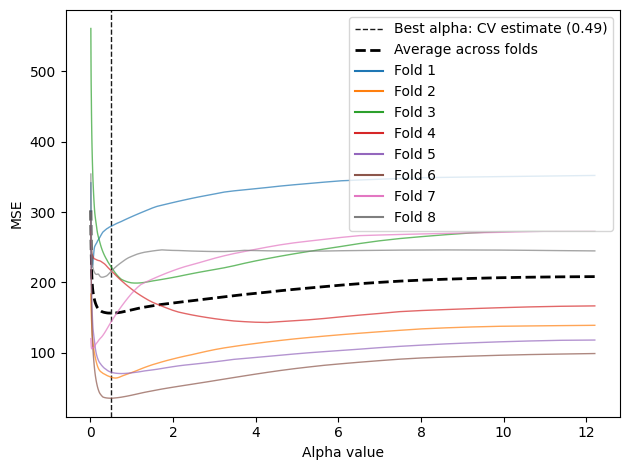

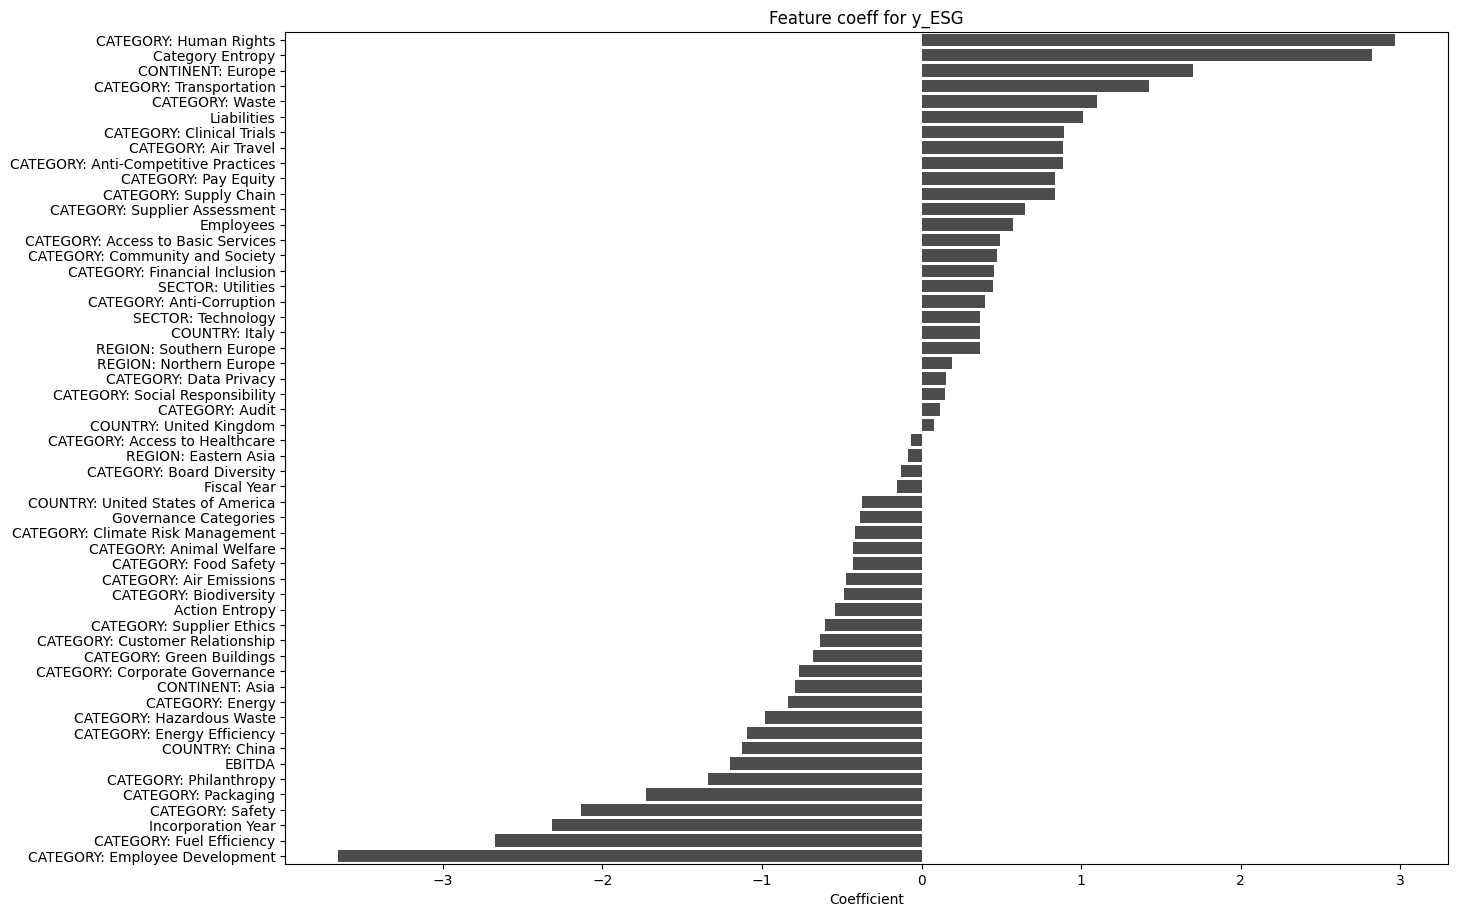

Training: y_Environmental... (Best alpha: 0.21)


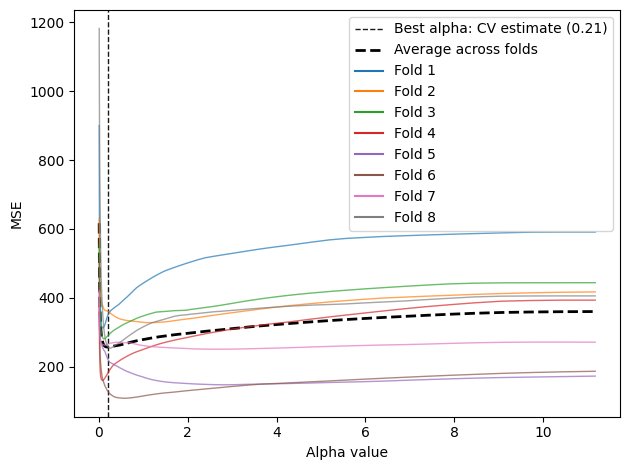

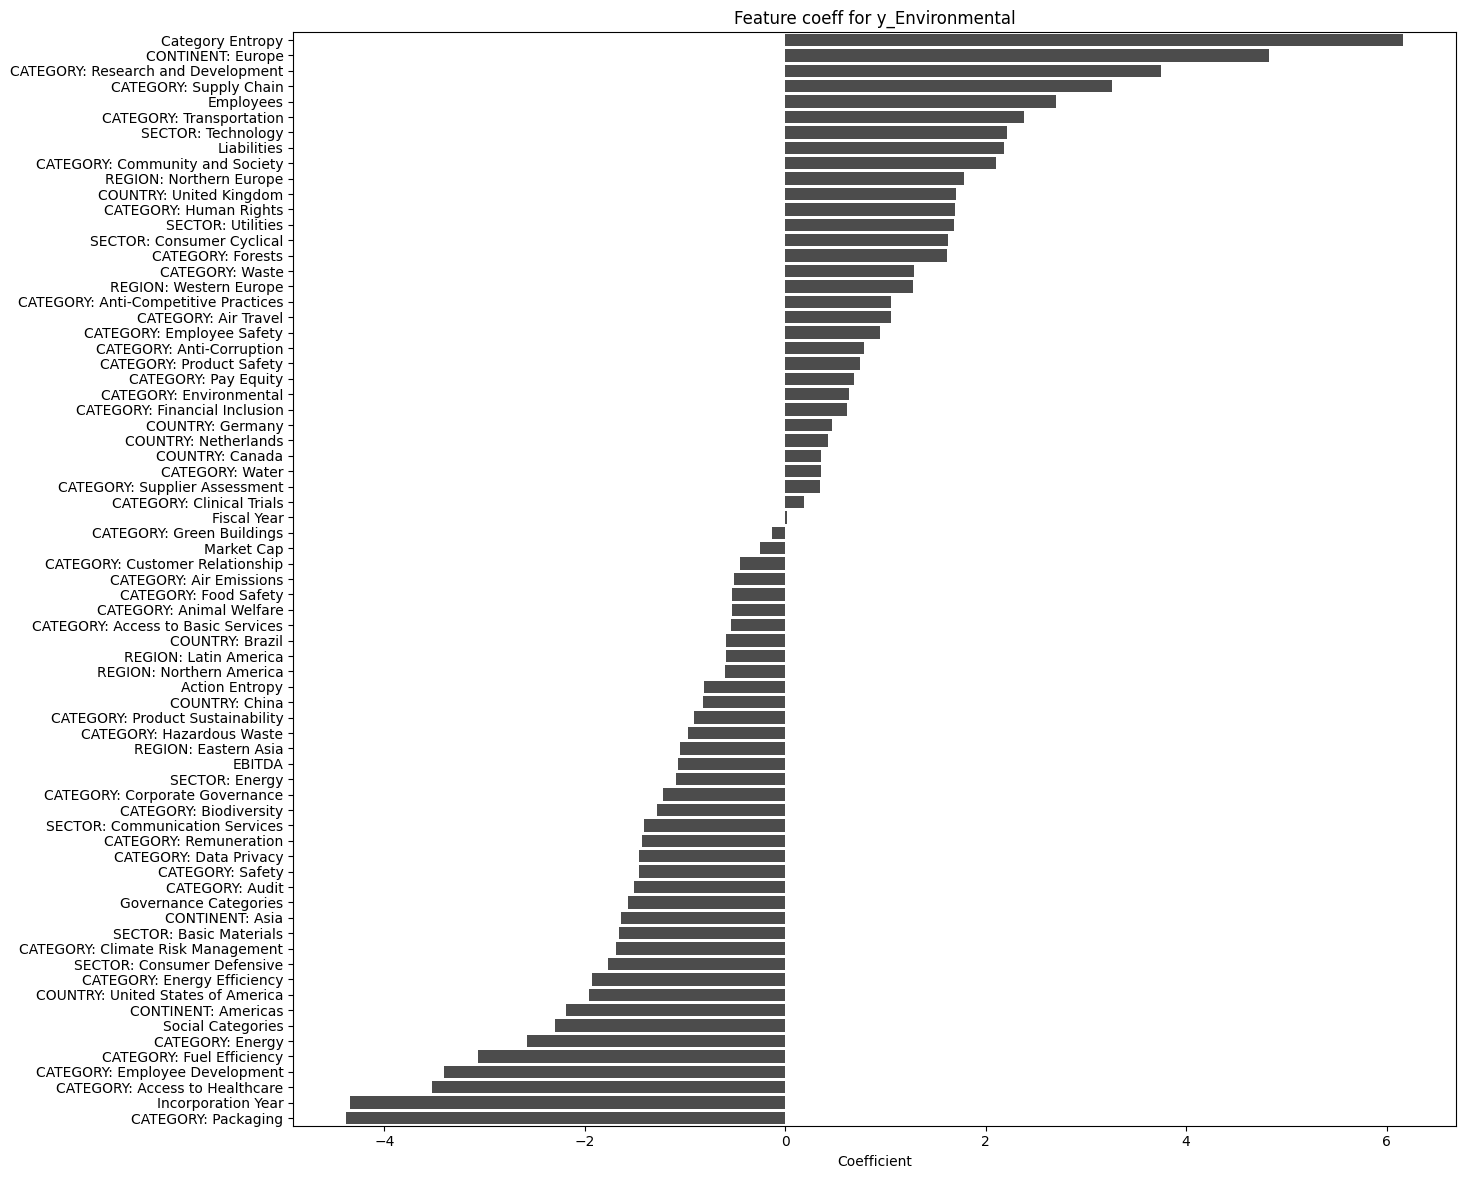

Training: y_Social... (Best alpha: 0.68)


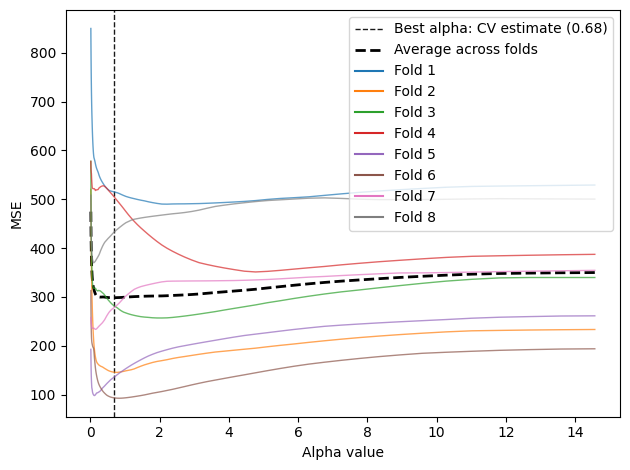

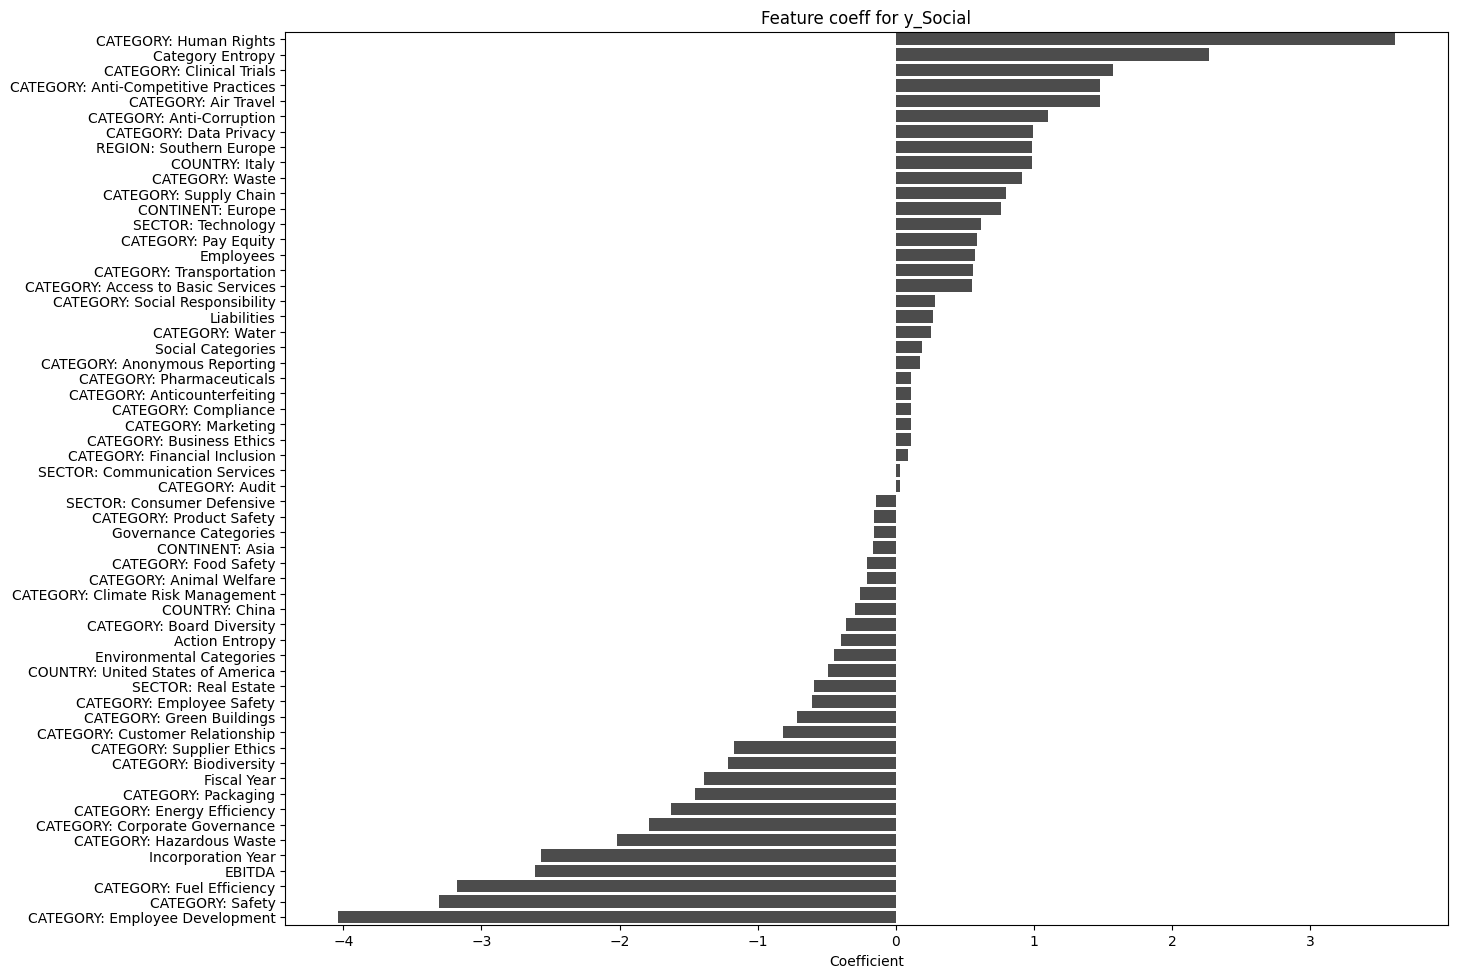

Training: y_Governance... (Best alpha: 2.3)


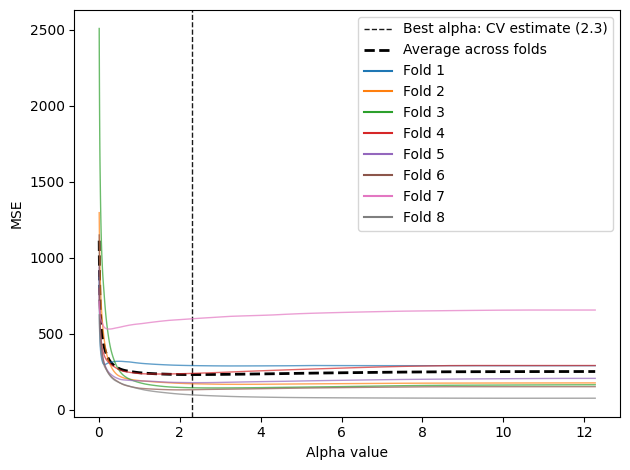

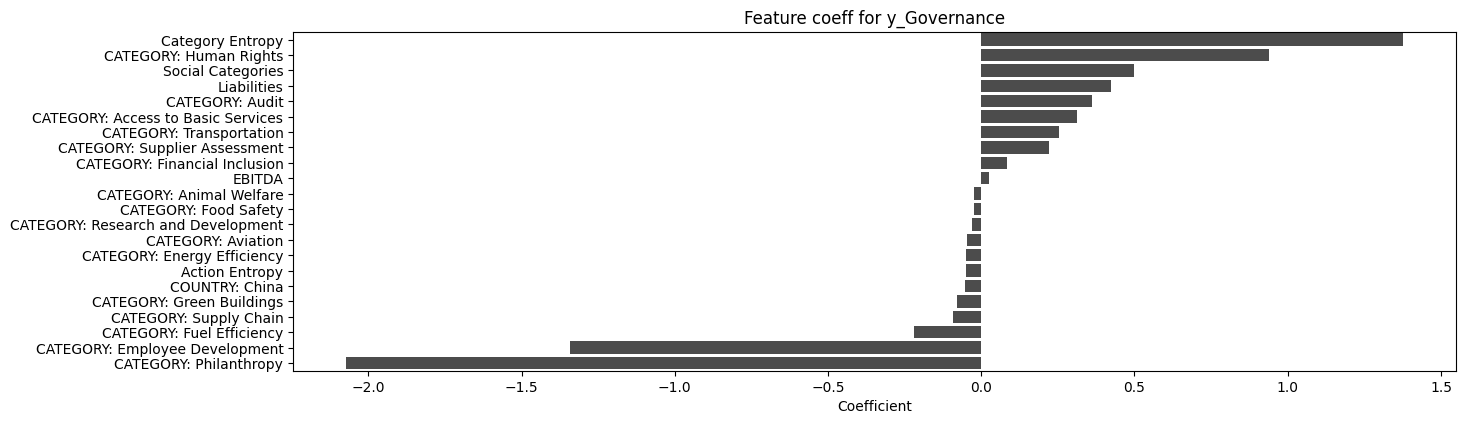

In [34]:
models = dict()
for y_name in input_data['y_names']:
    if grid_search:
        #reg_model = LassoCV(cv = 5, fit_intercept = True, positive = False,  max_iter = 10**6, random_state = 101)
        reg_model = ElasticNetCV(cv = 8, fit_intercept = True, positive = False,  max_iter = 10**6, random_state = 101)
        reg_model.fit(X = input_data['x'], y = input_data[y_name])

        print(f"Training: {y_name}... (Best alpha: {round(reg_model.alpha_, 2)})")
        cv_performance =  pd.DataFrame(
            data = reg_model.mse_path_,
            columns = [f'Fold {i}' for i in range(1, reg_model.mse_path_[0].shape[0] + 1)], 
            index = reg_model.alphas_)
        
        plt.axvline(reg_model.alpha_, linestyle="--", color="k", label=f"Best alpha: CV estimate ({round(reg_model.alpha_, 2)})", 
                    alpha = 0.9, linewidth = 1)   
        sns.lineplot(cv_performance.mean(axis = 1), label = 'Average across folds', color = 'black', linestyle="--", linewidth = 2)
        sns.lineplot(data = cv_performance, dashes = False, linewidth = 1, alpha = 0.7)
        plt.xlabel('Alpha value')
        plt.ylabel('MSE')
        plt.legend()
        plt.tight_layout()
        plt.savefig(path.join(training_path, f'{y_name}_CVperformance.pdf'))
        plt.show()
    else:
        reg_model = Lasso(alpha = 1, fit_intercept = True, positive = False,  max_iter =  10**5, random_state = 101)
        reg_model.fit(X = input_data['x'], y = input_data[y_name])
        print(f"Training: {y_name}...")
        
    # Save the model
    models[y_name] = reg_model
    
    # Coefficient plot
    coeff_df = pd.Series(reg_model.coef_, index = input_data['x'].columns).sort_values(ascending = False)
    coeff_df = coeff_df[coeff_df.abs() > 0.01 ]
    plt.figure(figsize = (15,  len(coeff_df)/ 5))
    plt.title(f"Feature coeff for {y_name}")
    sns.barplot(y = coeff_df.index, x = coeff_df.to_numpy(), color = 'black', alpha = 0.7)
    plt.xlabel('Coefficient')
    plt.show()

## Predictions

In [35]:
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error, mean_absolute_percentage_error

In [36]:
verbose = False

In [37]:
performance = defaultdict(dict)
for yName, model in models.items():
    
    # Generate predictions
    y_pred = model.predict(input_data['x']).flatten()
    
    # Create the prediction dataframe
    predictions_df = pd.DataFrame({
        'y_true': input_data[yName].flatten(), 
        'y_pred': y_pred, 
    }, index = input_data['x'].index)
    predictions_df['residual'] = predictions_df['y_true'] - predictions_df['y_pred']
    predictions_df['abs residual'] = predictions_df['residual'].abs()
    predictions_df['residual (%)'] = round(predictions_df['abs residual'] / predictions_df['y_true'].abs(), 3)
    
    if verbose:
        print(f'Preditions for {yName}')
        display(predictions_df.round(2))
    
    # Metrics 
    metrics_df = pd.Series({
        'r2': r2_score(predictions_df['y_true'], predictions_df['y_pred']),
        'MAE': mean_absolute_error(predictions_df['y_true'], predictions_df['y_pred']),
        'RMSE': mean_squared_error(predictions_df['y_true'], predictions_df['y_pred'], squared = False),
        'wMAPE (%)': predictions_df['residual'].abs().sum() / predictions_df['y_true'].abs().sum(),
        #'pos_wape': np.mean(np.abs(residuals[residuals >= 0]))/np.mean(np.abs(y_test)),
        #'neg_wape': np.mean(np.abs(residuals[residuals < 0]))/np.mean(np.abs(y_test)),
    }, name = yName)
    metrics_df['alpha_param'] = model.alpha_ if 'alpha_' in model.__dict__.keys() else model.alpha
    
    # Save the performance
    performance['metrics'][yName] = metrics_df
    performance['predictions'][yName] = predictions_df
    
performance['metrics'] = pd.concat(performance['metrics'].values(), axis = 1).T
display(performance['metrics'].round(2))

,r2,MAE,RMSE,wMAPE (%),alpha_param
y_ESG,0.71,5.78,7.76,0.08,0.49
y_Environmental,0.79,6.64,8.72,0.09,0.21
y_Social,0.66,8.28,10.78,0.11,0.68
y_Governance,0.22,10.88,13.98,0.15,2.30


## Save model perfomance

In [38]:
with pd.ExcelWriter(path.join(saving_path, f'regressionPerformance.xlsx')) as writer: #f'regressionDegree{polynomial_degree}.xlsx')
    
    for perfomanceName, perfomance_dfs in performance.items():
        
        if isinstance(perfomance_dfs, dict):
            for y_name, y_df in perfomance_dfs.items():
                y_df.index = pd.MultiIndex.from_tuples([index.split('|') for index in y_df.index], names = ['company', 'FY'])
                y_df.to_excel(writer, sheet_name = y_name)

                if y_df.index.levels[0].duplicated().any():
                    y_df.groupby(level = 0).agg(['mean', 'median','std']).round(2).to_excel(writer, sheet_name = y_name + '_averagedCompany')
                    y_df.groupby(level = 1).agg(['mean','median', 'std']).round(2).to_excel(writer, sheet_name = y_name + '_averagedYear')
                
        else:
            perfomance_dfs.to_excel(writer, sheet_name = perfomanceName)

## Check residuals

In [39]:
from statsmodels.stats.diagnostic import normal_ad
from statsmodels.api import qqplot

In [40]:
residuals_path = path.join(saving_path, 'residual_analysis')
if not path.exists(residuals_path):
    makedirs(residuals_path)

In [41]:
for yName, predictions_df in performance['predictions'].items():
    
    # Check normality
    test_value, normality_pvalue = normal_ad(predictions_df['residual'])
    isNormal = False if normality_pvalue < 0.05 else True
    #print('Residuals:', '' if isNormal else 'NOT' , 'normally distributed',  f'(p-value = {round(normality_pvalue, 4)})')

    fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize=(10, 8))

    # Target VS Predicted (check linearity)
    sns.scatterplot(data = predictions_df, x = 'y_true', y = 'y_pred', alpha = 0.5, s = 10, color = 'firebrick', ax = axes[0][0])
    axes[0][0].axline((predictions_df['y_true'].min(), predictions_df['y_pred'].min()), (predictions_df['y_true'].max(), predictions_df['y_pred'].max()), 
                    color='black', linestyle='--', alpha = 0.5, lw = 2)
    axes[0][0].set_title('Predicted VS target', fontsize = 20, color = 'firebrick')

    # Residual vs predicted (check homoscedasticity)
    sns.scatterplot(data = predictions_df, x = 'y_pred', y = 'residual', alpha = 0.5, s = 10, color = 'firebrick', ax = axes[0][1])
    axes[0][1].axhline(y = 0, color='black', linestyle='--', alpha = 0.5, lw = 2)
    axes[0][1].set_title('Residuals VS Predicted', fontsize = 20, color = 'firebrick')

    # Normal error distribution (check normality)
    sns.histplot(predictions_df['residual'], bins = 50, kde = True, color = 'firebrick', ax = axes[1][0], alpha = 0.6, line_kws={'linewidth': 4, 'alpha':0.9})
    axes[1][0].axvline(x = predictions_df['residual'].mean(), color='black', linestyle='--', label = 'Mean',  lw = 3)
    axes[1][0].set_title(f"Residual distribution", fontsize = 20, color = 'firebrick')
    axes[1][0].text(0.24, 0.58, f"Anderson-Darling test:\n{'no ' if not isNormal else ''}normal distribution\n\n(p-value: {round(normality_pvalue, 4)})", 
                    horizontalalignment='center', verticalalignment='center', transform=axes[1][0].transAxes, fontsize = 10)
    axes[1][0].legend()

    qqplot(predictions_df['residual'], alpha = 0.5, ax = axes[1][1], line = 'q') #, line = 's',
    axes[1][1].set_title('QQ plot', fontsize = 20, color = 'firebrick', pad = 7)

    fig.tight_layout()
    fig.savefig(path.join(residuals_path, f'residuals_{yName}.pdf')) #_degree{polynomial_degree}
    plt.close()

# Explainability

In [42]:
filtering = True

In [43]:
if filtering:
    
    # Retrieve company information
    companyInfos = company_information_filtered.loc[input_data['x'].index,:]
    referenceInfo = companyInfos.loc['Sony Corporation|2022']  
    
    # Filter the companies
    filtering_feature = 'Region of Headquarters'
    filtered_companies = companyInfos[companyInfos[filtering_feature] == referenceInfo[filtering_feature]]
    
    # Filter the input data
    input_data['x'] = input_data['x'].loc[filtered_companies.index, :]
    
    # Build the filtering string
    filtering_string = f"Filtering by {filtering_feature.split()[0]}: {referenceInfo[filtering_feature]}"
    
    #filtered_companies.index = [item.split('|')[0] for item in filtered_companies.index]

In [44]:
explainability_path = path.join(saving_path, "explainability" + (filtering_string.replace(' ', '') if filtering else ""))

explainability_subpaths = ['featureImportance', 'featureImportanceWithEffects', 'decisionPlots', 'observationPlots']
for subpath in explainability_subpaths:
    if not path.exists(path.join(explainability_path,subpath)):
        makedirs(path.join(explainability_path,subpath))
if filtering:
    filtered_companies.to_excel(path.join(explainability_path, f'{referenceInfo[filtering_feature]}Companies.xlsx'))

In [45]:
import shap
from matplotlib.ticker import ScalarFormatter

In [46]:
all_shap_values = dict()
for yName, model in models.items():
          
    explainer = shap.LinearExplainer(model = model, masker = shap.maskers.Independent(data = input_data['x']))
    shap_values = explainer.shap_values(input_data['x'])
    
    # Save the shap values
    all_shap_values[yName] = pd.DataFrame(shap_values, columns = input_data['x'].columns).abs().agg([np.median, np.mean]).T.sort_values(by = ['median', 'mean'], ascending=False)
    all_shap_values[yName].columns = [f'{col} SHAP Value' for col in all_shap_values[yName].columns]
    
    # (1) Feature importance
    plt.figure()
    shap.summary_plot(shap_values, input_data['x'], plot_type="bar", show = False,  plot_size = (20, 8)) #, plot_size = (20, 8) 
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig(path.join(explainability_path, explainability_subpaths[0], f'featureImportance_{yName}.pdf'))
    plt.close()
    
    # (1B) Feature importance
    plt.figure(figsize=(20, 8))
    sns.barplot(y = all_shap_values[yName].index[:20],  x = all_shap_values[yName]['median SHAP Value'].to_numpy()[:20], color = 'firebrick')
    plt.xlabel("median(|SHAP value|) (median impact on model output magnitude")
    plt.ylabel("Features")
    plt.tight_layout()
    plt.savefig(path.join(explainability_path, explainability_subpaths[0], f'medianFeatureImportance_{yName}.pdf'))
    plt.close()

    # (2) Feature importance with feature effects.
    plt.figure()
    #shap.summary_plot(shap_values, features = input_data['x'], show = False, plot_size = (20, 8), alpha = 0.8, sort = True)
    shap.plots.beeswarm(explainer(input_data['x']), show = False, plot_size = (14, 6), alpha = 0.7, max_display=17, log_scale = True) #order = shap.Explanation.abs.median(0)) # Modified in the libary
    if filtering:
        plt.title(filtering_string, fontsize = 15)
    plt.tight_layout()
    formatter = ScalarFormatter(useMathText=True, useOffset = False) 
    plt.gca().xaxis.set_major_formatter(formatter) 
    plt.savefig(path.join(explainability_path,  explainability_subpaths[1], f'featureImportanceWithEffects_{yName}.pdf'))
    plt.close()

    # (3) Heatmap
    shap.plots.heatmap(explainer(input_data['x']), show = False, plot_width = 20, max_display = 15)
    plt.savefig(path.join(explainability_path,  explainability_subpaths[2], f'heatMap_{yName}.pdf'))
    plt.close()
    
    # (3) Decision plots
    shap.decision_plot(explainer.expected_value, shap_values, features = input_data['x'], alpha = 0.4, show = False, auto_size_plot = True)
    plt.xlabel(f'Model output ({yName.split("_")[1].capitalize()} score)')
    plt.gcf().set_size_inches(20, 10)
    plt.tight_layout()
    plt.savefig(path.join(explainability_path,  explainability_subpaths[2], f'decisionPlot_{yName}.pdf'))
    plt.close()
    
    #plt.figure()
    #shap.plots.force(explainer.expected_value, shap_values)
    #plt.show()
    
    # (4) Waterfall
    #if yName == 'y_ESG':
    observationExplainer_path = path.join(explainability_path,  explainability_subpaths[3], yName)
    if not path.exists(observationExplainer_path):
        makedirs(observationExplainer_path)
        
    explainer_values = explainer(input_data['x'])        
    for idk, explained_obs in enumerate(explainer_values):
        obs = performance['predictions'][yName].iloc[idk]

        plt.figure()
        #plt.text(x = obs['y_true'] * 0.9, y = 10.2, s = f"y_true = {round(obs['y_true'], 2)}", fontsize=11, rotation=0, alpha = 0.3)
        plt.axvline(x = obs['y_true'], color = 'black', label = f"True value\n   ({round(obs['y_true'], 2)})", linestyle = '-', alpha = 0.8, linewidth = 0.5)
        plt.suptitle(f'(residual: {round(obs["residual"], 1)})', x = 0.52, y = 0.98, fontsize = 16) #, loc = 'left'
        plt.title(f'{obs.name[0]} | {obs.name[1]}', fontsize = 35, y = 1.02, x = 0.27) #y = 1.06, x = 0.2

        plt.legend(loc = 'center right')
        plt.xlabel(yName.split('_')[1] + ' score', fontsize = 25, labelpad = 20)
        plt.ylabel('Standardised feature values', fontsize = 20,  labelpad = 10)
        #
        shap.plots.waterfall(explained_obs, max_display = 15, show = False)
        plt.gcf().set_size_inches(14, 8)
        plt.gcf().tight_layout()
        
        plt.savefig(path.join(observationExplainer_path, f"{obs.name[0].replace(' ', '')}_{yName}.pdf"))
        plt.close()

All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 
All values for SymLogScale are below linthresh, making it effectivel

In [47]:
with pd.ExcelWriter(path.join(saving_path, f'regressionCoeff.xlsx')) as writer:
    for yName, model in models.items():
        
        # Generate a datagrame for the coefficients
        coeff_df = pd.DataFrame(model.coef_, index = input_data['x'].columns, columns = ['Regression coefficient'])
 
        # Concatenate the shap values with the coefficients
        df_to_save = all_shap_values[yName].join(coeff_df, how = 'inner')
        
        #pd.concat([all_shap_values[yName], coeff_df], axis = 1)
        df_to_save = df_to_save.sort_values(by = df_to_save.columns.tolist(), ascending = False)
        
        # Save to excel
        df_to_save.to_excel(writer, sheet_name = yName)